# Schrodinger equation
---

$$
\begin{aligned}
\varepsilon u_t - i\frac{\epsilon^2}{2}\Delta u + i V(x)u = 0, \ t \in \mathbb{R}, x\in \mathbb{R}^d, \\
u(x, t = 0) = u_0(x),
\end{aligned}
$$
where $V$ is a given electrostatic potential, $0 < \varepsilon \ll 1$.

---

Example 2 in Shi Jin's paper:
$$
u(x, 0) = \sqrt{n_0(x)}e^{iS_0(x)/\varepsilon},
$$
(3.9-3.10)
$$
n_0(x) = (e^{-25(x-0.5)^2})^2, \ S_0(x) = 0.2(x^2 - x).
$$

Periodic BC.

---

Consider the real and imag part of $u$, i.e., 
$$
u(x, t) = p(x, t) + iq(x, t),
$$
then
$$
\begin{aligned}
&\varepsilon p_t+\frac{\varepsilon^2}{2}q_{xx} - V(x)q = 0, \\
&\varepsilon q_t-\frac{\varepsilon^2}{2}p_{xx} + V(x)p = 0,
\end{aligned}
$$
with ic
$$
p(x, 0) = e^{-25(x-0.5)^2}\cos(\frac{0.2(x^2-x)}{\varepsilon}), \ q(x, 0) = e^{-25(x-0.5)^2}\sin(\frac{0.2(x^2-x)}{\varepsilon}),
$$
and bc
$$
p(0, t) = p(1, t), q(0, t) = q(1, t), p_x(0, t) = p_x(1, t), q_x(0, t) = q_x(1, t).
$$

In [1]:
NAME = "3_siren_time_marching_sampling_iterative"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers

import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple

In [3]:
key = random.PRNGKey(1)
key, subkey = random.split(key, 2)

layers = [2] + [64]*4 + [2] # (x, t) -> (u, v)
c0 = 6.0
# w0 = jnp.array([[1.0], [1.0]]) # (w_x, w_t)
w0 = 1.0
w1 = 1.0
lambda_0 = 1e-8
direct_params = init_siren_params(subkey, layers, c0, w0, w1)
# direct_params = init_tanh_params(subkey, layers)

domain = jnp.array([[0., 0.], [1., 0.5]])
epsilon = 1.0
V = 1.0

@jax.jit
def model(params, xt):
	# first, normalize to [-1, 1]
	xt = 2.0*(xt - domain[0, :])/(domain[1, :]-domain[0, :]) - 1.0
	for w, b in params[:-1]:
# 		xt = jax.nn.swish(jnp.dot(xt, w) + b)
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model)
hessian = hessian_fn(model)

In [4]:
# uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
# u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
# duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
# du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
# duv_dxxtt_c = hessian(direct_params, jnp.hstack([collocation.x, collocation.t]))
# du_dxx_c, dv_dxx_c = duv_dxxtt_c[:, 0:1, 0, 0], duv_dxxtt_c[:, 1:2, 0, 0]

# uv_l = model(direct_params, jnp.hstack([periodic_bc.l, periodic_bc.t]))
# uv_r = model(direct_params, jnp.hstack([periodic_bc.r, periodic_bc.t]))
# u_l, v_l = uv_l[:, 0:1], uv_l[:, 1:2]
# u_r, v_r = uv_r[:, 0:1], uv_r[:, 1:2]

# duv_dxt_l = jacobian(direct_params, jnp.hstack([periodic_bc.l, periodic_bc.t]))
# duv_dxt_r = jacobian(direct_params, jnp.hstack([periodic_bc.r, periodic_bc.t]))
# du_dx_l, dv_dx_l = duv_dxt_l[:, 0:1, 0], duv_dxt_l[:, 1:2, 0]
# du_dx_r, dv_dx_r = duv_dxt_r[:, 0:1, 0], duv_dxt_r[:, 1:2, 0]

# uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
# u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]

In [5]:
# 	loss_c1 = metaloss(epsilon*du_dt_c + 0.5*epsilon**2*dv_dxx_c - V*v_c, 0)
# 	loss_c2 = metaloss(epsilon*dv_dt_c - 0.5*epsilon**2*du_dxx_c + V*u_c, 0)
# 	loss_c = loss_c1 + loss_c2
	
# 	loss_d1 = metaloss(u_d, dirichlet.u)
# 	loss_d2 = metaloss(v_d, dirichlet.v)
# 	loss_d = loss_d1 + loss_d2
	
# 	loss_pbc_d1 = metaloss(u_l, u_r)
# 	loss_pbc_d2 = metaloss(v_l, v_r)
# 	loss_pbc_n1 = metaloss(du_dx_l, du_dx_r)
# 	loss_pbc_n2 = metaloss(dv_dx_l, dv_dx_r)
# 	loss_pbc_d = loss_pbc_d1 + loss_pbc_d2
# 	loss_pbc_n = loss_pbc_n1 + loss_pbc_n2

In [6]:
metaloss = mae

jit_conservation = lambda i: jax.partial(jax.jit, static_argnums = i)

@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet, periodic_bc = batch["collocation"], batch["dirichlet"], batch["periodic_bc"]
	direct_params = params
	
	uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
	u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
	
	# jacobian[i] = [[du/dx, du/dt],
	#                [dv/dx, dv/dt]]
	# i: the i^th input
	duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
	du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
	
	# hessian[i] = [
    #				[[du/dxx, du/dxy],
	#                [du/dxy, du/dyy]],
	#               [[dv/dxx, dv/dxy],
	#                [dv/dxy, dv/dyy]]
	#              ]
	duv_dxxtt_c = hessian(direct_params, jnp.hstack([collocation.x, collocation.t]))
	du_dxx_c, dv_dxx_c = duv_dxxtt_c[:, 0:1, 0, 0], duv_dxxtt_c[:, 1:2, 0, 0] 
	
	uv_l = model(direct_params, jnp.hstack([periodic_bc.l, periodic_bc.t]))
	uv_r = model(direct_params, jnp.hstack([periodic_bc.r, periodic_bc.t]))
	u_l, v_l = uv_l[:, 0:1], uv_l[:, 1:2]
	u_r, v_r = uv_r[:, 0:1], uv_r[:, 1:2]
	
	duv_dxt_l = jacobian(direct_params, jnp.hstack([periodic_bc.l, periodic_bc.t]))
	duv_dxt_r = jacobian(direct_params, jnp.hstack([periodic_bc.r, periodic_bc.t]))
	du_dx_l, dv_dx_l = duv_dxt_l[:, 0:1, 0], duv_dxt_l[:, 1:2, 0]
	du_dx_r, dv_dx_r = duv_dxt_r[:, 0:1, 0], duv_dxt_r[:, 1:2, 0]
		
	uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
	u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]
	
	loss_c1 = metaloss(epsilon*du_dt_c + 0.5*epsilon**2*dv_dxx_c - V*v_c, 0)
	loss_c2 = metaloss(epsilon*dv_dt_c - 0.5*epsilon**2*du_dxx_c + V*u_c, 0)
	loss_c = loss_c1 + loss_c2
	
	loss_d1 = metaloss(u_d, dirichlet.u)
	loss_d2 = metaloss(v_d, dirichlet.v)
	loss_d = loss_d1 + loss_d2
	
	loss_pbc_d1 = metaloss(u_l, u_r)
	loss_pbc_d2 = metaloss(v_l, v_r)
	loss_pbc_n1 = metaloss(du_dx_l, du_dx_r)
	loss_pbc_n2 = metaloss(dv_dx_l, dv_dx_r)
	loss_pbc_d = loss_pbc_d1 + loss_pbc_d2
	loss_pbc_n = loss_pbc_n1 + loss_pbc_n2
	
	return loss_c, loss_d, loss_pbc_d, loss_pbc_n


@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c, loss_d, loss_pbc_d, loss_pbc_n = loss_fn_(params, batch)
	return w["c"]*loss_c + w["d"]*loss_d + w["pbc_d"]*loss_pbc_d + w["pbc_n"]*loss_pbc_n + l2_regularization(params, lambda_0)

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c, loss_d, loss_pbc_d, loss_pbc_n = loss_fn_(params, batch)
	return w["c"]*loss_c + w["d"]*loss_d + w["pbc_d"]*loss_pbc_d + w["pbc_n"]*loss_pbc_n, loss_c, loss_d, loss_pbc_d, loss_pbc_n

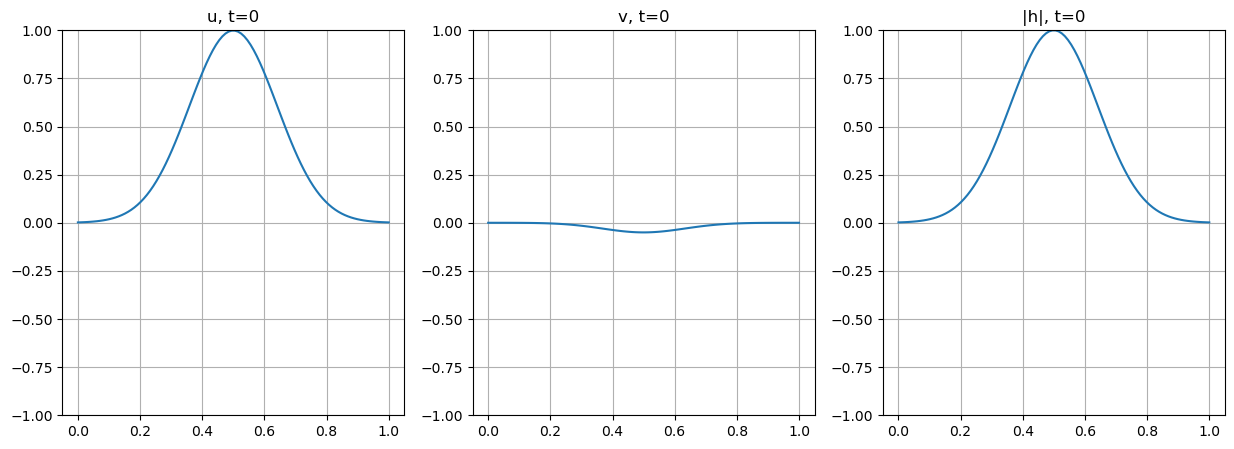

In [7]:
u0_fn = lambda x, t: np.exp(-25*(x-0.5)**2)*np.cos(0.2/epsilon*(x**2-x))
v0_fn = lambda x, t: np.exp(-25*(x-0.5)**2)*np.sin(0.2/epsilon*(x**2-x))
x0 = np.linspace(*domain[:, 0], 100)
t0 = np.zeros_like(x0)
u0 = u0_fn(x0, t0)
v0 = v0_fn(x0, t0)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

f, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].plot(x0, u0)
ax[0].set_title("u, t=0")
ax[0].grid()
ax[0].set_ylim([-1, 1])
ax[1].plot(x0, v0)
ax[1].set_title("v, t=0")
ax[1].grid()
ax[1].set_ylim([-1, 1])
ax[2].plot(x0, np.sqrt(u0**2+v0**2))
ax[2].set_title("|h|, t=0")
ax[2].grid()
ax[2].set_ylim([-1, 1])
plt.show()

key, *subkeys = random.split(key, 3)

n_i = 100
x_i = random.uniform(subkeys[0], (n_i, 1), jnp.float32, *domain[:, 0])
t_i = jnp.zeros_like(x_i)
u_i = u0_fn(x_i, t_i)
v_i = v0_fn(x_i, t_i)

n_b = 100
t_b = random.uniform(subkeys[1], (n_b, 1), jnp.float32, *domain[:, 1])
x_lb = jnp.ones_like(t_b)*domain[0, 0]
x_rb = jnp.ones_like(t_b)*domain[1, 0]

n_cx = 100
# n_ct = 20
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))
# t_c = jnp.linspace(*domain[:, 1], n_ct)
# xt_c = tensor_grid([x_c, t_c])

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u", "v"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])
dataset_BC = namedtuple("dataset_BC", ["l", "r", "t"])

dirichlet = dataset_Dirichlet(x_i, t_i, u_i, v_i)
periodic_bc = dataset_BC(x_lb, x_rb, t_b)
collocation = dataset_Collocation(jnp.vstack([dirichlet.x]),
								 jnp.vstack([dirichlet.t]))
# collocation = dataset_Collocation(jnp.vstack([dirichlet.x, periodic_bc.l, periodic_bc.r, xt_c[:, 0:1]]),
# 								  jnp.vstack([dirichlet.t, periodic_bc.t, periodic_bc.t, xt_c[:, 1:2]]))

class Time_Marching_Generator:
	def __init__(self, key, temporal_domain, batch_size, iterations, update_every):
		self.key = key
		self.domain = temporal_domain
		self.batch_size = batch_size
		self.iterations = iterations
		self._count1 = -1
		self._count2 = update_every
		self.update_every = update_every
		
	def _update(self, key, tmax):
		self._t = random.uniform(key, (self.batch_size, 1), jnp.float32, self.domain[0], tmax)
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self._count2 == self.update_every:
			self._count1 = max(self.iterations, self._count1 + 1)
			tmax = self.domain[0] + (self.domain[1]-self.domain[0])*self._count1/self.iterations
			self.key, subkey = random.split(self.key)
			self._update(subkey, tmax)
			self._count2 = 0
		else:
			self._count2 += 1
		return self._t

In [8]:
# pre-train

lr = 1e-3
start_iteration = 0
iterations = 5000
print_every = 1000
save_every = 10000
batch_size = {"dirichlet": 100, "bc": 100, "collocation": 100}
weights = {"c": 0.0, "d": 1.0, "pbc_d": 0.0, "pbc_n": 0.0}

key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
BC = Batch_Generator(subkeys[2], periodic_bc, batch_size["bc"])
Time = Time_Marching_Generator(subkeys[3], [0, 0.5], n_cx, iterations, 1)

params = direct_params

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

for iteration in range(start_iteration, start_iteration+iterations+1):
	t_c = next(Time)
	dc = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(jnp.vstack([dc[0], x_c]), jnp.vstack([dc[1], t_c])),
		"periodic_bc": dataset_BC(domain[0, 0]*jnp.ones_like(t_c), domain[1, 0]*jnp.ones_like(t_c), t_c),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "pbc_d", "pbc_n"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/10, 15:22:16, Iteration: 0, Train Loss: 6.5526e-01, c: 1.1918e+01, d: 6.5526e-01, pbc_d: 2.3505e+00, pbc_n: 2.4553e+00
2020/08/10, 15:22:30, Iteration: 1000, Train Loss: 4.5361e-02, c: 1.3066e+01, d: 4.5361e-02, pbc_d: 1.1942e+00, pbc_n: 1.3439e+00
2020/08/10, 15:22:44, Iteration: 2000, Train Loss: 3.3567e-02, c: 1.3376e+01, d: 3.3567e-02, pbc_d: 1.2305e+00, pbc_n: 1.4893e+00
2020/08/10, 15:22:58, Iteration: 3000, Train Loss: 3.4602e-02, c: 1.2756e+01, d: 3.4602e-02, pbc_d: 1.1056e+00, pbc_n: 1.7453e+00
2020/08/10, 15:23:13, Iteration: 4000, Train Loss: 3.1038e-02, c: 1.2060e+01, d: 3.1038e-02, pbc_d: 8.6972e-01, pbc_n: 1.4316e+00
2020/08/10, 15:23:27, Iteration: 5000, Train Loss: 1.4410e-02, c: 1.2057e+01, d: 1.4410e-02, pbc_d: 8.2705e-01, pbc_n: 1.3701e+00


In [9]:
# pre-train

lr = 1e-3
start_iteration = 0
iterations = 5000
print_every = 1000
save_every = 10000
batch_size = {"dirichlet": 100, "bc": 100, "collocation": 100}
weights = {"c": 1.0, "d": 0.0, "pbc_d": 1.0, "pbc_n": 1.0}

# key, *subkeys = random.split(key, 5)
# Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
# Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
# BC = Batch_Generator(subkeys[2], periodic_bc, batch_size["bc"])
# Time = Time_Marching_Generator(subkeys[3], [0, 0.5], n_cx, iterations, 1)


for iteration in range(start_iteration, start_iteration+iterations+1):
	t_c = next(Time)
	dc = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(jnp.vstack([dc[0], x_c]), jnp.vstack([dc[1], t_c])),
		"periodic_bc": dataset_BC(domain[0, 0]*jnp.ones_like(t_c), domain[1, 0]*jnp.ones_like(t_c), t_c),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "pbc_d", "pbc_n"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/10, 15:23:27, Iteration: 0, Train Loss: 1.1987e+01, c: 1.0645e+01, d: 2.6478e-02, pbc_d: 4.1450e-01, pbc_n: 9.2790e-01
2020/08/10, 15:23:42, Iteration: 1000, Train Loss: 1.5381e-01, c: 1.0214e-01, d: 3.7666e-01, pbc_d: 2.8337e-02, pbc_n: 2.3335e-02
2020/08/10, 15:23:56, Iteration: 2000, Train Loss: 7.6792e-02, c: 5.5368e-02, d: 3.7431e-01, pbc_d: 9.3150e-03, pbc_n: 1.2109e-02
2020/08/10, 15:24:10, Iteration: 3000, Train Loss: 8.6352e-02, c: 6.0159e-02, d: 3.6744e-01, pbc_d: 1.5734e-02, pbc_n: 1.0459e-02
2020/08/10, 15:24:25, Iteration: 4000, Train Loss: 4.3028e-02, c: 3.0630e-02, d: 3.6920e-01, pbc_d: 4.9173e-03, pbc_n: 7.4813e-03
2020/08/10, 15:24:39, Iteration: 5000, Train Loss: 7.1083e-02, c: 5.1332e-02, d: 3.7982e-01, pbc_d: 1.1295e-02, pbc_n: 8.4562e-03


In [10]:
# pre-train
for _ in range(10):
	lr = 1e-3
	start_iteration = 0
	iterations = 5000
	print_every = 1000
	save_every = 10000
	batch_size = {"dirichlet": 100, "bc": 100, "collocation": 100}
	weights = {"c": 0.0, "d": 1.0, "pbc_d": 0.0, "pbc_n": 0.0}

	# key, *subkeys = random.split(key, 5)
	# Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
	# Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
	# BC = Batch_Generator(subkeys[2], periodic_bc, batch_size["bc"])
	# Time = Time_Marching_Generator(subkeys[3], [0, 0.5], n_cx, iterations, 1)


	for iteration in range(start_iteration, start_iteration+iterations+1):
		t_c = next(Time)
		dc = next(Collocation)
		batch = {
			"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
			"collocation": dataset_Collocation(jnp.vstack([dc[0], x_c]), jnp.vstack([dc[1], t_c])),
			"periodic_bc": dataset_BC(domain[0, 0]*jnp.ones_like(t_c), domain[1, 0]*jnp.ones_like(t_c), t_c),
			"weights": weights
		}
		opt_state = step(iteration, opt_state, batch)
		if (iteration-start_iteration) % print_every == 0:
			names = ["Loss", "c", "d", "pbc_d", "pbc_n"]
			params_ = get_params(opt_state)
			losses = evaluate(params_, batch)
			print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
				  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
			hist["iter"].append(iteration)
			hist["loss"].append(losses)
		if (iteration-start_iteration) % save_every == 0:
			params_ = np.asarray(get_params(opt_state), dtype = object)
			save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
			if not os.path.exists(os.path.dirname(save_path)):
				os.makedirs(os.path.dirname(save_path))
			np.save(save_path, params_)
			
	weights = {"c": 1.0, "d": 0.0, "pbc_d": 1.0, "pbc_n": 1.0}

	for iteration in range(start_iteration, start_iteration+iterations+1):
		t_c = next(Time)
		dc = next(Collocation)
		batch = {
			"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
			"collocation": dataset_Collocation(jnp.vstack([dc[0], x_c]), jnp.vstack([dc[1], t_c])),
			"periodic_bc": dataset_BC(domain[0, 0]*jnp.ones_like(t_c), domain[1, 0]*jnp.ones_like(t_c), t_c),
			"weights": weights
		}
		opt_state = step(iteration, opt_state, batch)
		if (iteration-start_iteration) % print_every == 0:
			names = ["Loss", "c", "d", "pbc_d", "pbc_n"]
			params_ = get_params(opt_state)
			losses = evaluate(params_, batch)
			print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
				  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
			hist["iter"].append(iteration)
			hist["loss"].append(losses)
		if (iteration-start_iteration) % save_every == 0:
			params_ = np.asarray(get_params(opt_state), dtype = object)
			save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
			if not os.path.exists(os.path.dirname(save_path)):
				os.makedirs(os.path.dirname(save_path))
			np.save(save_path, params_)

2020/08/10, 15:24:39, Iteration: 0, Train Loss: 3.7246e-01, c: 4.8251e-02, d: 3.7246e-01, pbc_d: 1.1885e-02, pbc_n: 9.5095e-03
2020/08/10, 15:24:54, Iteration: 1000, Train Loss: 1.1040e-02, c: 7.3505e+00, d: 1.1040e-02, pbc_d: 1.3583e-01, pbc_n: 4.4116e-01
2020/08/10, 15:25:08, Iteration: 2000, Train Loss: 1.6008e-02, c: 6.7889e+00, d: 1.6008e-02, pbc_d: 1.1422e-01, pbc_n: 3.8072e-01
2020/08/10, 15:25:23, Iteration: 3000, Train Loss: 2.0292e-02, c: 7.2077e+00, d: 2.0292e-02, pbc_d: 1.4103e-01, pbc_n: 4.3496e-01
2020/08/10, 15:25:37, Iteration: 4000, Train Loss: 2.4358e-02, c: 7.0475e+00, d: 2.4358e-02, pbc_d: 1.5356e-01, pbc_n: 4.7600e-01
2020/08/10, 15:25:51, Iteration: 5000, Train Loss: 1.5730e-02, c: 7.4484e+00, d: 1.5730e-02, pbc_d: 2.0559e-01, pbc_n: 5.4495e-01
2020/08/10, 15:25:51, Iteration: 0, Train Loss: 7.1966e+00, c: 6.5332e+00, d: 3.7866e-02, pbc_d: 1.8717e-01, pbc_n: 4.7623e-01
2020/08/10, 15:26:06, Iteration: 1000, Train Loss: 4.5030e-02, c: 2.5732e-02, d: 3.5080e-01, pbc

2020/08/10, 15:37:32, Iteration: 4000, Train Loss: 1.0153e-02, c: 6.0652e+00, d: 1.0153e-02, pbc_d: 1.1805e-01, pbc_n: 3.0984e-01
2020/08/10, 15:37:47, Iteration: 5000, Train Loss: 8.4451e-03, c: 5.7167e+00, d: 8.4451e-03, pbc_d: 1.1686e-01, pbc_n: 2.9577e-01
2020/08/10, 15:37:47, Iteration: 0, Train Loss: 5.3900e+00, c: 5.0245e+00, d: 2.2089e-02, pbc_d: 1.0630e-01, pbc_n: 2.5922e-01
2020/08/10, 15:38:01, Iteration: 1000, Train Loss: 1.3658e-02, c: 1.2620e-02, d: 3.7121e-01, pbc_d: 2.8952e-04, pbc_n: 7.4801e-04
2020/08/10, 15:38:15, Iteration: 2000, Train Loss: 6.5468e-03, c: 5.9812e-03, d: 3.6284e-01, pbc_d: 2.0404e-04, pbc_n: 3.6150e-04
2020/08/10, 15:38:30, Iteration: 3000, Train Loss: 1.2697e-02, c: 1.1984e-02, d: 3.6200e-01, pbc_d: 2.6655e-04, pbc_n: 4.4622e-04
2020/08/10, 15:38:44, Iteration: 4000, Train Loss: 4.0539e-03, c: 3.3949e-03, d: 3.6539e-01, pbc_d: 1.8990e-04, pbc_n: 4.6909e-04
2020/08/10, 15:38:58, Iteration: 5000, Train Loss: 7.3867e-03, c: 6.6796e-03, d: 3.6876e-01, 

In [11]:
# pre-train
for _ in range(100):
	lr = 1e-3
	start_iteration = 0
	iterations = 5000
	print_every = 1000
	save_every = 10000
	batch_size = {"dirichlet": 100, "bc": 100, "collocation": 100}
	weights = {"c": 0.0, "d": 1.0, "pbc_d": 0.0, "pbc_n": 0.0}

	# key, *subkeys = random.split(key, 5)
	# Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
	# Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
	# BC = Batch_Generator(subkeys[2], periodic_bc, batch_size["bc"])
	# Time = Time_Marching_Generator(subkeys[3], [0, 0.5], n_cx, iterations, 1)


	for iteration in range(start_iteration, start_iteration+iterations+1):
		t_c = next(Time)
		dc = next(Collocation)
		batch = {
			"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
			"collocation": dataset_Collocation(jnp.vstack([dc[0], x_c]), jnp.vstack([dc[1], t_c])),
			"periodic_bc": dataset_BC(domain[0, 0]*jnp.ones_like(t_c), domain[1, 0]*jnp.ones_like(t_c), t_c),
			"weights": weights
		}
		opt_state = step(iteration, opt_state, batch)
		if (iteration-start_iteration) % print_every == 0:
			names = ["Loss", "c", "d", "pbc_d", "pbc_n"]
			params_ = get_params(opt_state)
			losses = evaluate(params_, batch)
			print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
				  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
			hist["iter"].append(iteration)
			hist["loss"].append(losses)
		if (iteration-start_iteration) % save_every == 0:
			params_ = np.asarray(get_params(opt_state), dtype = object)
			save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
			if not os.path.exists(os.path.dirname(save_path)):
				os.makedirs(os.path.dirname(save_path))
			np.save(save_path, params_)
			
	weights = {"c": 1.0, "d": 0.0, "pbc_d": 1.0, "pbc_n": 1.0}

	for iteration in range(start_iteration, start_iteration+iterations+1):
		t_c = next(Time)
		dc = next(Collocation)
		batch = {
			"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
			"collocation": dataset_Collocation(jnp.vstack([dc[0], x_c]), jnp.vstack([dc[1], t_c])),
			"periodic_bc": dataset_BC(domain[0, 0]*jnp.ones_like(t_c), domain[1, 0]*jnp.ones_like(t_c), t_c),
			"weights": weights
		}
		opt_state = step(iteration, opt_state, batch)
		if (iteration-start_iteration) % print_every == 0:
			names = ["Loss", "c", "d", "pbc_d", "pbc_n"]
			params_ = get_params(opt_state)
			losses = evaluate(params_, batch)
			print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
				  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
			hist["iter"].append(iteration)
			hist["loss"].append(losses)
		if (iteration-start_iteration) % save_every == 0:
			params_ = np.asarray(get_params(opt_state), dtype = object)
			save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
			if not os.path.exists(os.path.dirname(save_path)):
				os.makedirs(os.path.dirname(save_path))
			np.save(save_path, params_)

2020/08/10, 15:48:30, Iteration: 0, Train Loss: 3.7124e-01, c: 1.0366e-02, d: 3.7124e-01, pbc_d: 2.2555e-04, pbc_n: 2.0443e-04
2020/08/10, 15:48:44, Iteration: 1000, Train Loss: 6.6801e-03, c: 5.3003e+00, d: 6.6801e-03, pbc_d: 2.5867e-02, pbc_n: 9.3730e-02
2020/08/10, 15:48:58, Iteration: 2000, Train Loss: 8.6709e-03, c: 5.1723e+00, d: 8.6709e-03, pbc_d: 2.7858e-02, pbc_n: 7.5576e-02
2020/08/10, 15:49:12, Iteration: 3000, Train Loss: 9.5198e-03, c: 5.1796e+00, d: 9.5198e-03, pbc_d: 4.2198e-02, pbc_n: 1.4101e-01
2020/08/10, 15:49:26, Iteration: 4000, Train Loss: 1.1111e-02, c: 5.1151e+00, d: 1.1111e-02, pbc_d: 5.5327e-02, pbc_n: 1.7110e-01
2020/08/10, 15:49:41, Iteration: 5000, Train Loss: 1.0769e-02, c: 5.4953e+00, d: 1.0769e-02, pbc_d: 5.1874e-02, pbc_n: 1.5789e-01
2020/08/10, 15:49:41, Iteration: 0, Train Loss: 5.1896e+00, c: 5.0051e+00, d: 1.9640e-02, pbc_d: 4.4259e-02, pbc_n: 1.4025e-01
2020/08/10, 15:49:55, Iteration: 1000, Train Loss: 7.8186e-03, c: 6.7011e-03, d: 3.6599e-01, pbc

2020/08/10, 16:01:08, Iteration: 4000, Train Loss: 5.9187e-03, c: 5.5249e+00, d: 5.9187e-03, pbc_d: 6.1236e-02, pbc_n: 2.3403e-01
2020/08/10, 16:01:21, Iteration: 5000, Train Loss: 3.5238e-03, c: 5.3308e+00, d: 3.5238e-03, pbc_d: 7.5594e-02, pbc_n: 2.8301e-01
2020/08/10, 16:01:21, Iteration: 0, Train Loss: 5.1647e+00, c: 4.8455e+00, d: 2.1634e-02, pbc_d: 6.7959e-02, pbc_n: 2.5130e-01
2020/08/10, 16:01:35, Iteration: 1000, Train Loss: 1.2709e-02, c: 1.1028e-02, d: 3.6016e-01, pbc_d: 3.2766e-04, pbc_n: 1.3534e-03
2020/08/10, 16:01:49, Iteration: 2000, Train Loss: 1.0366e-02, c: 9.9011e-03, d: 3.6053e-01, pbc_d: 1.2053e-04, pbc_n: 3.4420e-04
2020/08/10, 16:02:03, Iteration: 3000, Train Loss: 1.2712e-02, c: 1.2294e-02, d: 3.7128e-01, pbc_d: 1.6779e-04, pbc_n: 2.5062e-04
2020/08/10, 16:02:17, Iteration: 4000, Train Loss: 4.5055e-03, c: 4.3580e-03, d: 3.6293e-01, pbc_d: 6.3404e-05, pbc_n: 8.4119e-05
2020/08/10, 16:02:31, Iteration: 5000, Train Loss: 4.4388e-03, c: 4.3524e-03, d: 3.6384e-01, 

2020/08/10, 16:13:32, Iteration: 2000, Train Loss: 6.5212e-03, c: 6.0843e-03, d: 3.6715e-01, pbc_d: 1.6678e-04, pbc_n: 2.7008e-04
2020/08/10, 16:13:46, Iteration: 3000, Train Loss: 2.6137e-03, c: 2.4026e-03, d: 3.6302e-01, pbc_d: 7.8611e-05, pbc_n: 1.3246e-04
2020/08/10, 16:14:00, Iteration: 4000, Train Loss: 2.9109e-03, c: 2.7546e-03, d: 3.6627e-01, pbc_d: 6.1998e-05, pbc_n: 9.4258e-05
2020/08/10, 16:14:14, Iteration: 5000, Train Loss: 6.3457e-03, c: 6.1638e-03, d: 3.6858e-01, pbc_d: 8.3291e-05, pbc_n: 9.8595e-05
2020/08/10, 16:14:14, Iteration: 0, Train Loss: 3.6731e-01, c: 6.7904e-03, d: 3.6731e-01, pbc_d: 7.0659e-05, pbc_n: 8.3710e-05
2020/08/10, 16:14:28, Iteration: 1000, Train Loss: 6.9236e-03, c: 5.8316e+00, d: 6.9236e-03, pbc_d: 1.5879e-01, pbc_n: 3.2988e-01
2020/08/10, 16:14:42, Iteration: 2000, Train Loss: 6.2290e-03, c: 5.7322e+00, d: 6.2290e-03, pbc_d: 1.1853e-01, pbc_n: 3.5067e-01
2020/08/10, 16:14:56, Iteration: 3000, Train Loss: 5.6051e-03, c: 5.5084e+00, d: 5.6051e-03, 

2020/08/10, 16:26:13, Iteration: 1000, Train Loss: 6.4255e-03, c: 5.4398e+00, d: 6.4255e-03, pbc_d: 1.0554e-01, pbc_n: 2.8664e-01
2020/08/10, 16:26:28, Iteration: 2000, Train Loss: 5.5974e-03, c: 5.4087e+00, d: 5.5974e-03, pbc_d: 1.1264e-01, pbc_n: 2.4326e-01
2020/08/10, 16:26:42, Iteration: 3000, Train Loss: 6.6368e-03, c: 5.4121e+00, d: 6.6368e-03, pbc_d: 1.0231e-01, pbc_n: 2.8316e-01
2020/08/10, 16:26:56, Iteration: 4000, Train Loss: 2.9292e-03, c: 5.2574e+00, d: 2.9292e-03, pbc_d: 1.1779e-01, pbc_n: 2.8417e-01
2020/08/10, 16:27:10, Iteration: 5000, Train Loss: 2.7247e-03, c: 5.4660e+00, d: 2.7247e-03, pbc_d: 1.3194e-01, pbc_n: 3.0295e-01
2020/08/10, 16:27:10, Iteration: 0, Train Loss: 5.1592e+00, c: 4.8004e+00, d: 2.3268e-02, pbc_d: 1.1590e-01, pbc_n: 2.4295e-01
2020/08/10, 16:27:24, Iteration: 1000, Train Loss: 7.6510e-03, c: 7.1521e-03, d: 3.5553e-01, pbc_d: 1.5947e-04, pbc_n: 3.3942e-04
2020/08/10, 16:27:38, Iteration: 2000, Train Loss: 5.1584e-03, c: 4.6534e-03, d: 3.6206e-01, 

2020/08/10, 16:38:53, Iteration: 5000, Train Loss: 7.2678e-03, c: 5.7151e+00, d: 7.2678e-03, pbc_d: 1.2977e-01, pbc_n: 3.4619e-01
2020/08/10, 16:38:53, Iteration: 0, Train Loss: 5.3649e+00, c: 4.9482e+00, d: 2.6744e-02, pbc_d: 1.1741e-01, pbc_n: 2.9930e-01
2020/08/10, 16:39:07, Iteration: 1000, Train Loss: 6.7090e-03, c: 5.9996e-03, d: 3.6144e-01, pbc_d: 2.4097e-04, pbc_n: 4.6837e-04
2020/08/10, 16:39:21, Iteration: 2000, Train Loss: 4.1447e-03, c: 3.6514e-03, d: 3.6496e-01, pbc_d: 2.3881e-04, pbc_n: 2.5454e-04
2020/08/10, 16:39:36, Iteration: 3000, Train Loss: 3.5118e-03, c: 3.0916e-03, d: 3.6347e-01, pbc_d: 2.5604e-04, pbc_n: 1.6416e-04
2020/08/10, 16:39:50, Iteration: 4000, Train Loss: 4.4737e-03, c: 4.3446e-03, d: 3.6144e-01, pbc_d: 5.6538e-05, pbc_n: 7.2508e-05
2020/08/10, 16:40:04, Iteration: 5000, Train Loss: 5.2338e-03, c: 4.0801e-03, d: 3.6389e-01, pbc_d: 4.3974e-04, pbc_n: 7.1398e-04
2020/08/10, 16:40:04, Iteration: 0, Train Loss: 3.6312e-01, c: 4.7073e-03, d: 3.6312e-01, pbc

2020/08/10, 16:51:20, Iteration: 3000, Train Loss: 2.8068e-03, c: 2.6854e-03, d: 3.6559e-01, pbc_d: 4.7628e-05, pbc_n: 7.3780e-05
2020/08/10, 16:51:34, Iteration: 4000, Train Loss: 5.7689e-04, c: 5.2251e-04, d: 3.6395e-01, pbc_d: 2.2780e-05, pbc_n: 3.1594e-05
2020/08/10, 16:51:48, Iteration: 5000, Train Loss: 2.8003e-03, c: 2.7264e-03, d: 3.6341e-01, pbc_d: 2.9674e-05, pbc_n: 4.4189e-05
2020/08/10, 16:51:48, Iteration: 0, Train Loss: 3.6247e-01, c: 2.9834e-03, d: 3.6247e-01, pbc_d: 3.2391e-05, pbc_n: 4.6935e-05
2020/08/10, 16:52:03, Iteration: 1000, Train Loss: 6.1760e-03, c: 5.6352e+00, d: 6.1760e-03, pbc_d: 2.0206e-01, pbc_n: 6.8571e-01
2020/08/10, 16:52:17, Iteration: 2000, Train Loss: 1.0124e-02, c: 5.5661e+00, d: 1.0124e-02, pbc_d: 1.3490e-01, pbc_n: 5.1749e-01
2020/08/10, 16:52:31, Iteration: 3000, Train Loss: 9.5564e-03, c: 5.5167e+00, d: 9.5564e-03, pbc_d: 1.4629e-01, pbc_n: 4.6320e-01
2020/08/10, 16:52:45, Iteration: 4000, Train Loss: 5.7279e-03, c: 5.7433e+00, d: 5.7279e-03, 

2020/08/10, 17:03:46, Iteration: 1000, Train Loss: 1.3889e-02, c: 5.1072e+00, d: 1.3889e-02, pbc_d: 7.9968e-02, pbc_n: 1.7038e-01
2020/08/10, 17:04:00, Iteration: 2000, Train Loss: 8.1490e-03, c: 5.0807e+00, d: 8.1490e-03, pbc_d: 7.5793e-02, pbc_n: 1.7106e-01
2020/08/10, 17:04:14, Iteration: 3000, Train Loss: 5.7803e-03, c: 5.0096e+00, d: 5.7803e-03, pbc_d: 7.8466e-02, pbc_n: 1.9412e-01
2020/08/10, 17:04:29, Iteration: 4000, Train Loss: 4.4130e-03, c: 5.1458e+00, d: 4.4130e-03, pbc_d: 8.7342e-02, pbc_n: 2.2625e-01
2020/08/10, 17:04:43, Iteration: 5000, Train Loss: 5.6317e-03, c: 5.4080e+00, d: 5.6317e-03, pbc_d: 1.0243e-01, pbc_n: 2.1824e-01
2020/08/10, 17:04:43, Iteration: 0, Train Loss: 4.9351e+00, c: 4.6941e+00, d: 2.7389e-02, pbc_d: 8.1017e-02, pbc_n: 1.5999e-01
2020/08/10, 17:04:57, Iteration: 1000, Train Loss: 4.1039e-03, c: 3.6514e-03, d: 3.6241e-01, pbc_d: 2.0416e-04, pbc_n: 2.4827e-04
2020/08/10, 17:05:12, Iteration: 2000, Train Loss: 2.5353e-03, c: 2.2130e-03, d: 3.6567e-01, 

2020/08/10, 17:16:31, Iteration: 5000, Train Loss: 5.0262e-03, c: 4.8418e+00, d: 5.0262e-03, pbc_d: 5.5786e-02, pbc_n: 6.2146e-02
2020/08/10, 17:16:31, Iteration: 0, Train Loss: 4.3269e+00, c: 4.2179e+00, d: 1.7869e-02, pbc_d: 5.4209e-02, pbc_n: 5.4744e-02
2020/08/10, 17:16:45, Iteration: 1000, Train Loss: 6.1554e-03, c: 5.6167e-03, d: 3.5983e-01, pbc_d: 1.8202e-04, pbc_n: 3.5673e-04
2020/08/10, 17:17:00, Iteration: 2000, Train Loss: 3.6730e-03, c: 3.3626e-03, d: 3.6081e-01, pbc_d: 1.5339e-04, pbc_n: 1.5701e-04
2020/08/10, 17:17:14, Iteration: 3000, Train Loss: 4.5683e-03, c: 4.3067e-03, d: 3.6730e-01, pbc_d: 1.1714e-04, pbc_n: 1.4445e-04
2020/08/10, 17:17:29, Iteration: 4000, Train Loss: 2.4723e-03, c: 2.3368e-03, d: 3.6663e-01, pbc_d: 5.6027e-05, pbc_n: 7.9512e-05
2020/08/10, 17:17:43, Iteration: 5000, Train Loss: 2.5977e-03, c: 2.4435e-03, d: 3.6229e-01, pbc_d: 7.1638e-05, pbc_n: 8.2519e-05
2020/08/10, 17:17:43, Iteration: 0, Train Loss: 3.6053e-01, c: 3.7053e-03, d: 3.6053e-01, pbc

2020/08/10, 17:29:16, Iteration: 3000, Train Loss: 4.1318e-03, c: 3.8828e-03, d: 3.6392e-01, pbc_d: 1.1240e-04, pbc_n: 1.3658e-04
2020/08/10, 17:29:30, Iteration: 4000, Train Loss: 1.6801e-03, c: 1.5464e-03, d: 3.6531e-01, pbc_d: 6.2620e-05, pbc_n: 7.1113e-05
2020/08/10, 17:29:45, Iteration: 5000, Train Loss: 1.3776e-03, c: 1.2918e-03, d: 3.6282e-01, pbc_d: 3.3162e-05, pbc_n: 5.2624e-05
2020/08/10, 17:29:45, Iteration: 0, Train Loss: 3.6019e-01, c: 2.3538e-03, d: 3.6019e-01, pbc_d: 3.9199e-05, pbc_n: 7.0032e-05
2020/08/10, 17:29:59, Iteration: 1000, Train Loss: 1.3195e-02, c: 5.0117e+00, d: 1.3195e-02, pbc_d: 1.9313e-02, pbc_n: 3.4386e-02
2020/08/10, 17:30:13, Iteration: 2000, Train Loss: 4.0145e-03, c: 4.8127e+00, d: 4.0145e-03, pbc_d: 3.1084e-02, pbc_n: 3.6076e-02
2020/08/10, 17:30:28, Iteration: 3000, Train Loss: 6.7897e-03, c: 4.9338e+00, d: 6.7897e-03, pbc_d: 2.9791e-02, pbc_n: 4.2880e-02
2020/08/10, 17:30:42, Iteration: 4000, Train Loss: 5.5495e-03, c: 5.0203e+00, d: 5.5495e-03, 

2020/08/10, 17:41:59, Iteration: 1000, Train Loss: 7.9090e-03, c: 4.9029e+00, d: 7.9090e-03, pbc_d: 1.2870e-02, pbc_n: 3.2908e-02
2020/08/10, 17:42:14, Iteration: 2000, Train Loss: 5.5707e-03, c: 4.9156e+00, d: 5.5707e-03, pbc_d: 1.6055e-02, pbc_n: 3.0685e-02
2020/08/10, 17:42:28, Iteration: 3000, Train Loss: 6.2744e-03, c: 4.8329e+00, d: 6.2744e-03, pbc_d: 2.2459e-02, pbc_n: 4.2307e-02
2020/08/10, 17:42:43, Iteration: 4000, Train Loss: 7.1142e-03, c: 4.9462e+00, d: 7.1142e-03, pbc_d: 2.0574e-02, pbc_n: 3.3441e-02
2020/08/10, 17:42:56, Iteration: 5000, Train Loss: 3.4863e-03, c: 4.8002e+00, d: 3.4863e-03, pbc_d: 3.0720e-02, pbc_n: 4.5074e-02
2020/08/10, 17:42:56, Iteration: 0, Train Loss: 4.4790e+00, c: 4.4109e+00, d: 1.9987e-02, pbc_d: 2.2611e-02, pbc_n: 4.5478e-02
2020/08/10, 17:43:09, Iteration: 1000, Train Loss: 5.3536e-03, c: 5.1178e-03, d: 3.7243e-01, pbc_d: 8.4912e-05, pbc_n: 1.5096e-04
2020/08/10, 17:43:21, Iteration: 2000, Train Loss: 3.1265e-03, c: 2.9804e-03, d: 3.6589e-01, 

2020/08/10, 17:53:55, Iteration: 5000, Train Loss: 6.7312e-03, c: 5.1209e+00, d: 6.7312e-03, pbc_d: 2.1429e-02, pbc_n: 7.2225e-02
2020/08/10, 17:53:55, Iteration: 0, Train Loss: 4.7537e+00, c: 4.6701e+00, d: 1.8995e-02, pbc_d: 2.3822e-02, pbc_n: 5.9784e-02
2020/08/10, 17:54:09, Iteration: 1000, Train Loss: 3.4980e-03, c: 3.3392e-03, d: 3.6239e-01, pbc_d: 7.1840e-05, pbc_n: 8.6959e-05
2020/08/10, 17:54:24, Iteration: 2000, Train Loss: 2.8958e-03, c: 2.8041e-03, d: 3.6509e-01, pbc_d: 3.5801e-05, pbc_n: 5.5868e-05
2020/08/10, 17:54:38, Iteration: 3000, Train Loss: 2.5924e-03, c: 2.4965e-03, d: 3.6207e-01, pbc_d: 3.8261e-05, pbc_n: 5.7646e-05
2020/08/10, 17:54:52, Iteration: 4000, Train Loss: 2.7779e-03, c: 2.6752e-03, d: 3.6419e-01, pbc_d: 2.9776e-05, pbc_n: 7.2843e-05
2020/08/10, 17:55:06, Iteration: 5000, Train Loss: 1.2183e-03, c: 1.1776e-03, d: 3.6396e-01, pbc_d: 1.5653e-05, pbc_n: 2.5050e-05
2020/08/10, 17:55:06, Iteration: 0, Train Loss: 3.6133e-01, c: 2.4478e-03, d: 3.6133e-01, pbc

2020/08/10, 18:06:08, Iteration: 3000, Train Loss: 2.3154e-03, c: 2.1113e-03, d: 3.6389e-01, pbc_d: 9.8192e-05, pbc_n: 1.0590e-04
2020/08/10, 18:06:22, Iteration: 4000, Train Loss: 1.4704e-03, c: 1.3102e-03, d: 3.6431e-01, pbc_d: 6.6875e-05, pbc_n: 9.3316e-05
2020/08/10, 18:06:36, Iteration: 5000, Train Loss: 9.2518e-04, c: 8.0471e-04, d: 3.6397e-01, pbc_d: 5.3215e-05, pbc_n: 6.7262e-05
2020/08/10, 18:06:36, Iteration: 0, Train Loss: 3.6223e-01, c: 1.5369e-03, d: 3.6223e-01, pbc_d: 7.7081e-05, pbc_n: 1.0617e-04
2020/08/10, 18:06:50, Iteration: 1000, Train Loss: 4.7693e-03, c: 4.8990e+00, d: 4.7693e-03, pbc_d: 3.7840e-02, pbc_n: 6.4374e-02
2020/08/10, 18:07:04, Iteration: 2000, Train Loss: 9.2880e-03, c: 4.9586e+00, d: 9.2880e-03, pbc_d: 2.6049e-02, pbc_n: 5.5647e-02
2020/08/10, 18:07:18, Iteration: 3000, Train Loss: 4.2056e-03, c: 4.9503e+00, d: 4.2056e-03, pbc_d: 3.6556e-02, pbc_n: 8.4502e-02
2020/08/10, 18:07:32, Iteration: 4000, Train Loss: 4.9838e-03, c: 5.0388e+00, d: 4.9838e-03, 

2020/08/10, 18:18:28, Iteration: 1000, Train Loss: 6.8375e-03, c: 4.6961e+00, d: 6.8375e-03, pbc_d: 1.3591e-02, pbc_n: 1.4557e-02
2020/08/10, 18:18:42, Iteration: 2000, Train Loss: 5.6529e-03, c: 4.7305e+00, d: 5.6529e-03, pbc_d: 2.4004e-02, pbc_n: 2.1350e-02
2020/08/10, 18:18:56, Iteration: 3000, Train Loss: 6.2858e-03, c: 4.6974e+00, d: 6.2858e-03, pbc_d: 2.0862e-02, pbc_n: 2.5192e-02
2020/08/10, 18:19:10, Iteration: 4000, Train Loss: 7.6289e-03, c: 4.7194e+00, d: 7.6289e-03, pbc_d: 2.1228e-02, pbc_n: 1.8894e-02
2020/08/10, 18:19:24, Iteration: 5000, Train Loss: 4.2376e-03, c: 4.8321e+00, d: 4.2376e-03, pbc_d: 2.1346e-02, pbc_n: 2.5748e-02
2020/08/10, 18:19:24, Iteration: 0, Train Loss: 4.4525e+00, c: 4.4136e+00, d: 2.2868e-02, pbc_d: 1.4665e-02, pbc_n: 2.4248e-02
2020/08/10, 18:19:39, Iteration: 1000, Train Loss: 5.0329e-03, c: 4.9318e-03, d: 3.6727e-01, pbc_d: 4.0429e-05, pbc_n: 6.0659e-05
2020/08/10, 18:19:53, Iteration: 2000, Train Loss: 3.8822e-03, c: 3.8326e-03, d: 3.6431e-01, 

2020/08/10, 18:31:02, Iteration: 5000, Train Loss: 2.8159e-03, c: 4.8767e+00, d: 2.8159e-03, pbc_d: 2.0877e-02, pbc_n: 1.0320e-01
2020/08/10, 18:31:02, Iteration: 0, Train Loss: 4.4586e+00, c: 4.3910e+00, d: 2.1265e-02, pbc_d: 1.8908e-02, pbc_n: 4.8655e-02
2020/08/10, 18:31:16, Iteration: 1000, Train Loss: 5.2578e-03, c: 5.1650e-03, d: 3.6940e-01, pbc_d: 4.4628e-05, pbc_n: 4.8181e-05
2020/08/10, 18:31:30, Iteration: 2000, Train Loss: 3.6763e-03, c: 3.5981e-03, d: 3.6876e-01, pbc_d: 3.4130e-05, pbc_n: 4.4070e-05
2020/08/10, 18:31:44, Iteration: 3000, Train Loss: 3.0913e-03, c: 3.0342e-03, d: 3.6234e-01, pbc_d: 2.5586e-05, pbc_n: 3.1482e-05
2020/08/10, 18:31:58, Iteration: 4000, Train Loss: 1.3397e-03, c: 1.2511e-03, d: 3.6323e-01, pbc_d: 2.1665e-05, pbc_n: 6.6972e-05
2020/08/10, 18:32:11, Iteration: 5000, Train Loss: 1.4728e-03, c: 1.0629e-03, d: 3.6329e-01, pbc_d: 1.3396e-04, pbc_n: 2.7590e-04
2020/08/10, 18:32:11, Iteration: 0, Train Loss: 3.6014e-01, c: 3.4239e-03, d: 3.6014e-01, pbc

2020/08/10, 18:42:15, Iteration: 3000, Train Loss: 7.8036e-03, c: 7.6650e-03, d: 3.6313e-01, pbc_d: 6.0562e-05, pbc_n: 7.8024e-05
2020/08/10, 18:42:28, Iteration: 4000, Train Loss: 1.5711e-03, c: 1.5117e-03, d: 3.6332e-01, pbc_d: 2.1571e-05, pbc_n: 3.7824e-05
2020/08/10, 18:42:40, Iteration: 5000, Train Loss: 3.1145e-03, c: 1.9949e-03, d: 3.6175e-01, pbc_d: 3.6976e-04, pbc_n: 7.4986e-04
2020/08/10, 18:42:40, Iteration: 0, Train Loss: 3.5909e-01, c: 3.1554e-03, d: 3.5909e-01, pbc_d: 4.1532e-04, pbc_n: 3.9385e-04
2020/08/10, 18:42:53, Iteration: 1000, Train Loss: 6.4353e-03, c: 4.6024e+00, d: 6.4353e-03, pbc_d: 1.3341e-02, pbc_n: 3.3256e-02
2020/08/10, 18:43:06, Iteration: 2000, Train Loss: 7.2126e-03, c: 4.6272e+00, d: 7.2126e-03, pbc_d: 1.0255e-02, pbc_n: 3.0899e-02
2020/08/10, 18:43:18, Iteration: 3000, Train Loss: 7.2490e-03, c: 4.6604e+00, d: 7.2490e-03, pbc_d: 1.0560e-02, pbc_n: 3.1500e-02
2020/08/10, 18:43:31, Iteration: 4000, Train Loss: 3.8677e-03, c: 4.6468e+00, d: 3.8677e-03, 

2020/08/10, 18:53:21, Iteration: 1000, Train Loss: 4.9837e-03, c: 4.9225e+00, d: 4.9837e-03, pbc_d: 1.0072e-02, pbc_n: 2.2391e-02
2020/08/10, 18:53:33, Iteration: 2000, Train Loss: 3.7768e-03, c: 4.6979e+00, d: 3.7768e-03, pbc_d: 1.2349e-02, pbc_n: 2.5762e-02
2020/08/10, 18:53:46, Iteration: 3000, Train Loss: 4.0700e-03, c: 4.7318e+00, d: 4.0700e-03, pbc_d: 1.8012e-02, pbc_n: 3.4818e-02
2020/08/10, 18:53:58, Iteration: 4000, Train Loss: 8.6282e-03, c: 4.7933e+00, d: 8.6282e-03, pbc_d: 2.2567e-02, pbc_n: 3.8172e-02
2020/08/10, 18:54:11, Iteration: 5000, Train Loss: 5.0159e-03, c: 4.8050e+00, d: 5.0159e-03, pbc_d: 2.2934e-02, pbc_n: 4.2022e-02
2020/08/10, 18:54:11, Iteration: 0, Train Loss: 4.3972e+00, c: 4.3241e+00, d: 2.6992e-02, pbc_d: 2.1653e-02, pbc_n: 5.1444e-02
2020/08/10, 18:54:23, Iteration: 1000, Train Loss: 4.0522e-03, c: 3.8925e-03, d: 3.6655e-01, pbc_d: 6.4525e-05, pbc_n: 9.5121e-05
2020/08/10, 18:54:36, Iteration: 2000, Train Loss: 4.6666e-03, c: 4.5075e-03, d: 3.7066e-01, 

2020/08/10, 19:04:37, Iteration: 5000, Train Loss: 6.8294e-03, c: 4.6263e+00, d: 6.8294e-03, pbc_d: 1.4635e-02, pbc_n: 3.9921e-02
2020/08/10, 19:04:37, Iteration: 0, Train Loss: 4.2111e+00, c: 4.1569e+00, d: 2.8430e-02, pbc_d: 1.4342e-02, pbc_n: 3.9867e-02
2020/08/10, 19:04:49, Iteration: 1000, Train Loss: 4.2636e-03, c: 4.1468e-03, d: 3.7268e-01, pbc_d: 4.1344e-05, pbc_n: 7.5463e-05
2020/08/10, 19:05:02, Iteration: 2000, Train Loss: 2.7460e-03, c: 2.6438e-03, d: 3.6167e-01, pbc_d: 4.3908e-05, pbc_n: 5.8232e-05
2020/08/10, 19:05:14, Iteration: 3000, Train Loss: 1.7930e-03, c: 1.7266e-03, d: 3.6417e-01, pbc_d: 2.6094e-05, pbc_n: 4.0380e-05
2020/08/10, 19:05:27, Iteration: 4000, Train Loss: 1.1003e-03, c: 9.9407e-04, d: 3.6376e-01, pbc_d: 3.0228e-05, pbc_n: 7.6001e-05
2020/08/10, 19:05:39, Iteration: 5000, Train Loss: 8.7595e-04, c: 7.9778e-04, d: 3.6568e-01, pbc_d: 2.4519e-05, pbc_n: 5.3653e-05
2020/08/10, 19:05:39, Iteration: 0, Train Loss: 3.6379e-01, c: 8.5975e-04, d: 3.6379e-01, pbc

2020/08/10, 19:16:06, Iteration: 3000, Train Loss: 3.4185e-03, c: 3.2758e-03, d: 3.6143e-01, pbc_d: 5.5231e-05, pbc_n: 8.7490e-05
2020/08/10, 19:16:20, Iteration: 4000, Train Loss: 4.0918e-03, c: 3.9997e-03, d: 3.6891e-01, pbc_d: 2.7032e-05, pbc_n: 6.5125e-05
2020/08/10, 19:16:34, Iteration: 5000, Train Loss: 2.0523e-03, c: 1.9819e-03, d: 3.6624e-01, pbc_d: 2.0782e-05, pbc_n: 4.9614e-05
2020/08/10, 19:16:34, Iteration: 0, Train Loss: 3.6215e-01, c: 2.6560e-03, d: 3.6215e-01, pbc_d: 2.3544e-05, pbc_n: 4.4646e-05
2020/08/10, 19:16:48, Iteration: 1000, Train Loss: 1.0076e-02, c: 4.8043e+00, d: 1.0076e-02, pbc_d: 2.4627e-02, pbc_n: 7.2800e-02
2020/08/10, 19:17:02, Iteration: 2000, Train Loss: 2.2767e-03, c: 4.7537e+00, d: 2.2767e-03, pbc_d: 2.9634e-02, pbc_n: 7.2761e-02
2020/08/10, 19:17:16, Iteration: 3000, Train Loss: 4.8726e-03, c: 4.8245e+00, d: 4.8726e-03, pbc_d: 2.6426e-02, pbc_n: 7.8335e-02
2020/08/10, 19:17:30, Iteration: 4000, Train Loss: 3.3175e-03, c: 4.9318e+00, d: 3.3175e-03, 

2020/08/10, 19:28:28, Iteration: 1000, Train Loss: 5.9178e-03, c: 4.7982e+00, d: 5.9178e-03, pbc_d: 2.5710e-02, pbc_n: 4.6124e-02
2020/08/10, 19:28:42, Iteration: 2000, Train Loss: 7.4960e-03, c: 4.7682e+00, d: 7.4960e-03, pbc_d: 3.3498e-02, pbc_n: 9.2666e-02
2020/08/10, 19:28:56, Iteration: 3000, Train Loss: 5.2074e-03, c: 4.8820e+00, d: 5.2074e-03, pbc_d: 2.8325e-02, pbc_n: 8.0257e-02
2020/08/10, 19:29:09, Iteration: 4000, Train Loss: 2.7849e-03, c: 4.8566e+00, d: 2.7849e-03, pbc_d: 2.9637e-02, pbc_n: 1.0428e-01
2020/08/10, 19:29:23, Iteration: 5000, Train Loss: 8.9414e-03, c: 4.7793e+00, d: 8.9414e-03, pbc_d: 2.9210e-02, pbc_n: 1.4052e-01
2020/08/10, 19:29:23, Iteration: 0, Train Loss: 4.4488e+00, c: 4.3293e+00, d: 2.7543e-02, pbc_d: 3.4797e-02, pbc_n: 8.4711e-02
2020/08/10, 19:29:37, Iteration: 1000, Train Loss: 5.2748e-03, c: 5.0487e-03, d: 3.6220e-01, pbc_d: 9.7117e-05, pbc_n: 1.2895e-04
2020/08/10, 19:29:51, Iteration: 2000, Train Loss: 6.7413e-03, c: 6.5807e-03, d: 3.6211e-01, 

<IPython.core.display.Javascript object>


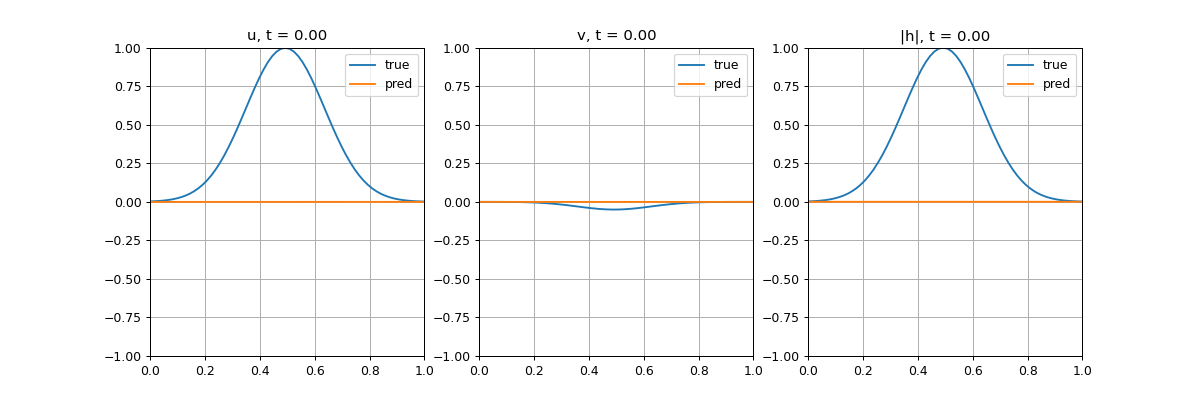

In [12]:
from scipy.io import loadmat

uv_true = loadmat("epsilon_1.0.mat")["u"].T

from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
lines = []
for i in range(3):
    line1, = ax[i].plot([], [], lw = 1.5, label = "true")
    line2, = ax[i].plot([], [], lw = 1.5, label = "pred")
    lines.extend([line1, line2])
    ax[i].set_xlim([0, 1])
    ax[i].set_ylim([-1, 1])
    ax[i].legend()
    ax[i].grid()
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

params_ = get_params(opt_state)

x_test = jnp.linspace(*domain[:, 0], 64)
t_test = jnp.linspace(*domain[:, 1], 101)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]
uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]

def animate(i):
	u_pred, v_pred = u_preds[i], v_preds[i]
	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
	lines[0].set_data(x_test, u_true)
	lines[1].set_data(x_test, u_pred)
	ax[0].set_title("u, t = {:.2f}".format(t_test[i]))
    
	lines[2].set_data(x_test, v_true)
	lines[3].set_data(x_test, v_pred)
	ax[1].set_title("v, t = {:.2f}".format(t_test[i]))

	lines[4].set_data(x_test, np.sqrt(u_true**2+v_true**2))
	lines[5].set_data(x_test, np.sqrt(u_pred**2+v_pred**2))
	ax[2].set_title("|h|, t = {:.2f}".format(t_test[i]))

	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 1000, blit = True)
plt.show()

In [13]:
uv_true.shape

(101, 64)